# Simulating ACT: An investigation

## Preliminaries

Our goal is to simulate noise of an ACT patch such that:
1. anisotropy is captured
2. inhomogenity is captured
3. the PS of the sim calculated the same way as on the data agree

We start by assuming no point sources exist (no holes in mask).
We first spell out what is done to calculate (3).
We have 4 splits of the data $d_i$ .
We have an apodized analysis mask $m_A$ . (No holes, 1s everywhere except for apodized edge)
We have inverse variance maps $m_i$ .
We define the joint mask $m^J_i=m_A m_i$ . (The actual joint mask Steve uses might be more complicated, e.g. point source holes and cross-linking, but we start with this simple case)
The coadd map is defined by $d^C = \sum_i m_i d_i / m_C$ where $m_C = \sum_i m_i$.

We define a general power spectrum operator $P(d_\alpha,d_\beta,w_\alpha,w_\beta)$. The naive version is $P^N(d_\alpha,d_\beta,w_\alpha,w_\beta) = \rm{FFT}(d_\alpha)\rm{FFT}(d_\beta)^*/~\langle w_\alpha w_\beta \rangle$. The proper operator $P^M$ accounts for mode coupling, and we will investigate this later. The best estimator $P^S$ (wielded by Steve, DW, etc.) uses SHTs, applies a k-space filter, corrects mode coupling and applies a transfer function. The latter two only give us a binned view of the power. 



## Noise power estimator

The operator $P$ can be used to obtain an estimate of the noise power. If all the weights were uniform (and identical), there is an optimal estimator:
$$
\hat{N}^O_{\alpha\beta} = \frac{1}{n(n-1)}\sum_i P(d^\alpha_i-d^\alpha_C,d^\beta_i-d^\beta_C,m^A,m^A)
$$

We use a generalized version of this

$$
\hat{N}^{GO}_{\alpha\beta} = \frac{1}{n(n-1)}\sum_i P(d^\alpha_i-d^\alpha_C,d^\beta_i-d^\beta_C,m^J_{i\alpha},m^J_{i\beta})
$$


This can be compared to the sub-optimal estimator
$$
\hat{N}^S_{\alpha\beta} = P(d^C_\alpha,d^C_\beta,m^J_{C\alpha},m^J_{C\beta}) - \frac{2}{n(n-1)}\sum_{i>j} P(d^i_\alpha,d^j_\beta,m^J_{i\alpha},m^J_{j\beta})
$$

Yet another estimator is (this is what Alex has been using)

$$
\hat{N}^X_{\alpha\beta} = \frac{1}{n^2}\sum_i P(d^i_\alpha,d^i_\beta,m^J_{i\alpha},m^J_{i\beta}) - \frac{2}{n^2(n-1)}\sum_{i>j} P(d^i_\alpha,d^j_\beta,m^J_{i\alpha},m^J_{j\beta})
$$

**First, we compare all three of the above on Deep6 data.**

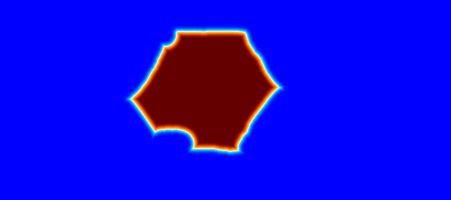

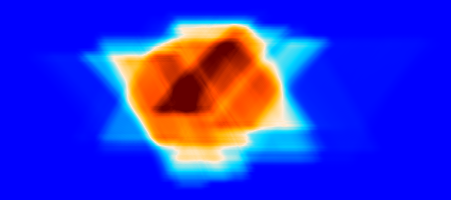

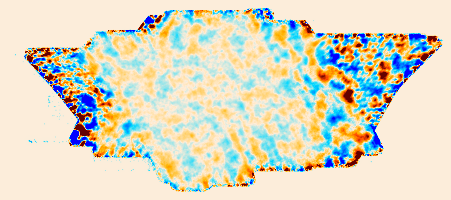

In [1]:
%load_ext autoreload
%autoreload 2
from pixell import enmap,enplot
import datamodel
import numpy as np
import matplotlib.pyplot as plt

# We load and visualize the data

plot = lambda imap : enplot.show(enplot.plot(enmap.downgrade(imap,8),grid=False))
dm = datamodel.DataModel("s13","pa1","deep6")
modlmap = enmap.modlmap(dm.shape,dm.wcs)
plot(dm.mask_a)
plot(dm.get_inv_var()[0][0][0])
plot(dm.get_map()[0][0][0])

In [11]:

"""
Here we set up a Power object that can eventually plug in to a mode coupling code.
We will only work with scalar (spin-0) spectra since our goal is to look at II,QQ,UU,IQ,IU,QU.
"""

class Power(object):
    def __init__(self,shape,wcs,mc=False):
        self.mc = mc
        self.shape = shape
        self.wcs = wcs
        if self.mc:
            self._wts = {}
        
    def add_weight(self,key,weight): # will be used to initialize a mode coupling mask
        # DW, Steve, Zack? Someone fill this in?
        self._wts[key] = weight.copy()
    
    def mc_power(self,m1,w1,m2=None,w2=None):
        # Implements P^M
        # DW, Steve, Zack? Someone fill this in?
        # In this situation w1 (and optionally w2) will be strings
        # that point to a dictionary of pre-calculated mode couplings
        raise NotImplementedError
    
    
    def naive_power(self,m1,w1,m2=None,w2=None): # same API as mc_power, but calculates naive power
        # Implements P^N
        f1 = enmap.fft(m1*w1,normalize="phys")
        if m2 is None:
            assert w2 is None
            f2 = f1.copy()
            w2 = w1.copy()
        else:
            f2 = enmap.fft(m2*w2,normalize="phys")
        norm = np.mean(w1*w2)
        return (f1*f2.conj()).real / norm
    
    def _expand_wts(self,wts):
        if self.mc: 
            return enmap.enmap(np.stack([self._weights[w] for w in wts]),self.wcs)
        else:
            return wts        
        
    
    def noise_power(self,coadds1,cweights1,imaps1,weights1,
                    coadds2=None,cweights2=None,imaps2=None,weights2=None,optimal=True,old_type=None):
        # Implements the generalized optimal estimator N^GO_alpha_beta
        # and the sub-optimal noise estimator N^S_alpha_beta
        # All weights must include the apodized mask
        # No weights must be applied before hand
        # coadds1 = (Ny,Nx) -- the coadd map
        # cweights1 = (Ny,Nx) -- the coadd weight
        # imaps1 = (nsplits,Ny,Nx) -- the split maps
        # weights1 = (nsplits,Ny,Nx) -- the weights for the splits
        
        # select the PS function
        pfunc = self.mc_power if self.mc else self.naive_power
        
        if optimal:
            # N^{GO} estimator
            assert old_type is None
            assert imaps1.ndim==3
            nsplits = imaps1.shape[0]
            if imaps2 is None: 
                assert weights2 is None
                assert coadds2 is None
                imaps2 = imaps1.copy()
                weights2 = weights1.copy()
                cweights2 = cweights1.copy()
                coadds2 = coadds1.copy()
            else: assert imaps2.shape[0]==nsplits
            noise = 0.
            for i in range(nsplits):
                diff1 = imaps1[i] - coadds1
                diff2 = imaps2[i] - coadds2
                noise = noise + pfunc(diff1,weights1[i],diff2,weights2[i])
            return noise / nsplits / (nsplits-1.)
                        
        else:
            # N^{S} estimator
            if old_type is None: old_type = False
            
            if not(old_type):
                # Coadd power
                if coadds2 is None:
                    assert cweights2 is None
                    assert imaps2 is None
                    assert weights2 is None
                    cpower = pfunc(coadds1,cweights1)
                else:
                    cpower = pfunc(coadds1,cweights1,coadds2,cweights2)
            
            # Cross and auto power
            assert imaps1.ndim==3
            nsplits = imaps1.shape[0]
            if imaps2 is None: assert weights2 is None
            else: assert imaps2.shape[0]==nsplits
            
            ncrosses = 0.
            nautos = 0.
            crosses = 0.
            autos = 0.
            imaps2 = imaps1.copy() if imaps2 is None else imaps2
            weights2 = weights1.copy() if weights2 is None else weights2
            for i in range(nsplits):
                for j in range(i,nsplits):
                    ret = pfunc(imaps1[i],weights1[i],imaps2[j],weights2[j])
                    if i!=j:
                        crosses = crosses + ret.copy()
                        ncrosses += 1
                    else:
                        autos = autos + ret.copy()
                        nautos += 1
            crosses = crosses / ncrosses
            autos = autos / nautos
            return (cpower - crosses) if not(old_type) else (autos-crosses)/nsplits
    
def get_coadd(imaps,wts):
    # sum(w*m)/sum(w)
    twt = np.sum(wts,axis=0)
    return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt
       
    
pobj = Power(dm.shape,dm.wcs,mc=False)

In [28]:
# We have to do the noise power calculation on an array by array basis, where each array points to some freq and I/Q/U. So for PA3 for example, there will be a loop over the following with 6*(6+1)/2 runs

ifreq = 0 # only one frequency for PA1
ipol = 0 # only doing TT for now

splits = dm.get_map()[ifreq,:,ipol]
wts = dm.get_inv_var()[ifreq,:,ipol]

coadds,cweights = get_coadd(splits,wts)


/home/msyriac/.local/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide


In [13]:
# We look at the noise power
# sub-optimal
p2d = pobj.noise_power(coadds,cweights*dm.mask_a,splits,wts*dm.mask_a,optimal=False)
# X estimator (Alex-style)
p2dS = pobj.noise_power(coadds,cweights*dm.mask_a,splits,wts*dm.mask_a,optimal=False,old_type=True)
# Generalized optimal estimator
p2dO = pobj.noise_power(coadds,cweights*dm.mask_a,splits,wts*dm.mask_a,optimal=True)

/home/msyriac/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


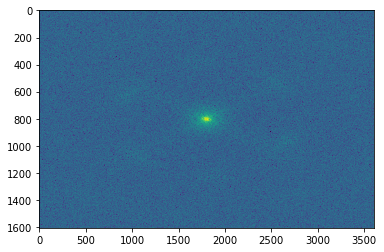

In [22]:
# X estimator (Alex)
plt.imshow(np.fft.fftshift(np.log10(p2dS)),aspect='auto')

**This looks nice.**

/home/msyriac/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


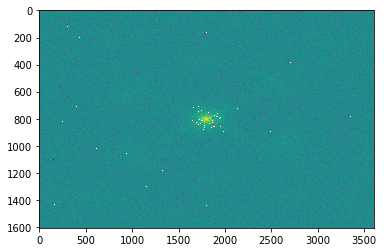

In [15]:
# Sub-optimal estimator
plt.imshow(np.fft.fftshift(np.log10(p2d)),aspect='auto')

#### We see unphysical negative power fluctuations in the sub-optimal estimator.

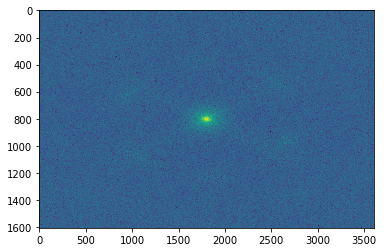

In [16]:
# Optimal estimator
plt.imshow(np.fft.fftshift(np.log10(p2dO)),aspect='auto')

**This also looks nice.**

In [17]:
bin_edges = np.arange(80,8000,80)
cents,p1d = datamodel.binned_power(p2d,modlmap,bin_edges)
cents,p1dS = datamodel.binned_power(p2dS,modlmap,bin_edges)
cents,p1dO = datamodel.binned_power(p2dO,modlmap,bin_edges)

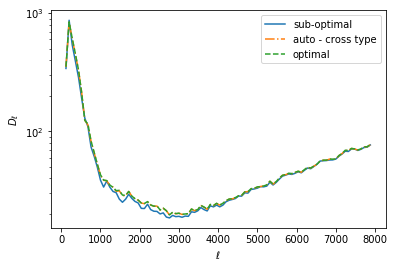

In [23]:
plt.plot(cents,p1d*cents**2./2./np.pi,label='sub-optimal')
plt.plot(cents,p1dS*cents**2./2./np.pi,ls="-.",label='auto - cross type')
plt.plot(cents,p1dO*cents**2./2./np.pi,ls="--",label="optimal")
plt.legend()
plt.xlabel("$\\ell$")
plt.ylabel("$D_{\\ell}$")
plt.xscale('linear')
plt.yscale('log')

#### We see considerable difference in power between the optimal estimator and the sub-optimal one at intermediate scales.

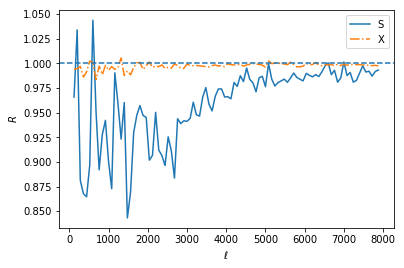

In [27]:
plt.plot(cents,p1d/p1dO,label='S')
plt.plot(cents,p1dS/p1dO,ls="-.",label='X')
plt.legend()
plt.axhline(y=1,ls="--")
plt.xlabel("$\\ell$")
plt.ylabel("$R$")
plt.xscale('linear')
plt.yscale('linear')

The optimal and (ale)X estimators are only 0.5% different, so we stick to the optimal one and consistently use it on the data and on the sims. **We have however learned the important lesson that the choice of noise PS estimator can lead to 15% differences.** 

In [29]:
# Save for later
deep6_power_2d = p2dO.copy()
deep6_power_1d = p1dO.copy()

## Flattened spectra

We now calculate flattened spectra from which GRFs are generated.

## Smoothing

We save noises that have and do not have smoothing.

## Covsqrt

We explore 6 different ways of square rooting the covariance matrix:
1. Multipow (with correlations)
2. Arrayops (with correlations)
3. Multipow (no correlations)
4. Arrayops (no correlations)
5. Multipow (I-I correlations)
6. Arrayops (I-I correlations)

The last two only apply to PA3. Together with smoothed and unsmoothed, this presents 12 possible combinations.

## Naive PS comparison

Do we get things to make sense on Deep6 PA1?

## The PA3 behemoth

Let's do the loop on PA3.

## Adding mode coupling

Assuming that the Power class has been completed, we can now loop in mode coupling to make sure that doesn't change anything.